In [1]:
import itertools
import functools
import dataclasses
import packaging.version
from typing import List, Sequence, Set, Iterator, Union

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

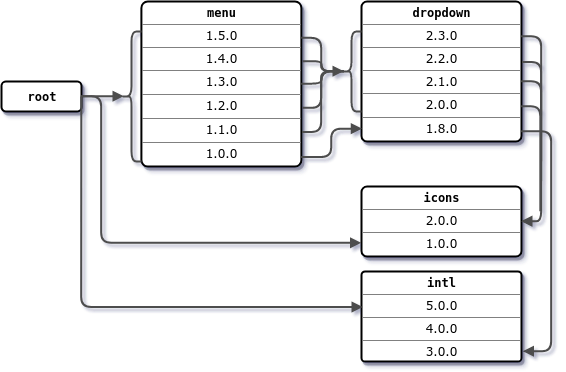

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
solver, pool = mer.problems.create_pubgrub_hard()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - package pyicons-1.0.0 requires libicons 1.**, but none of the providers can be installed
   


In [4]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [5]:
pbs

,type,source_id,source_is_pkg,dependency,dependency_id,target_id,target_is_pkg,explanation
0,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,18,True,libicons 1.**,-2147483632,0,False,"package pyicons-1.0.0 requires libicons 1.**, ..."
1,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,23,True,None,0,21,True,cannot install both libicons-1.2.0 and libicon...
2,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,24,True,None,0,21,True,cannot install both libicons-1.0.0 and libicon...
3,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,13,True,libicons 2.**,-2147483639,0,False,"package dropdown-2.0.0 requires libicons 2.**,..."
4,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,5,True,dropdown 2.**,-2147483647,0,False,"package menu-1.2.0 requires dropdown 2.**, but..."
5,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,10,True,libicons 2.**,-2147483639,0,False,"package dropdown-2.3.0 requires libicons 2.**,..."
6,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,24,True,None,0,19,True,cannot install both libicons-1.0.0 and libicon...
7,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,24,True,None,0,20,True,cannot install both libicons-1.0.0 and libicon...
8,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,23,True,None,0,19,True,cannot install both libicons-1.2.0 and libicon...
9,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,23,True,None,0,20,True,cannot install both libicons-1.2.0 and libicon...


In [6]:
deps

,dependency_id,solvable_id
0,-2147483632,22
1,-2147483632,23
2,-2147483632,24
3,-2147483639,19
4,-2147483639,20
5,-2147483639,21
6,-2147483647,10
7,-2147483647,11
8,-2147483647,12
9,-2147483647,13


In [7]:
solvables

,name,version,build_string,build_number
id,,,,
2,menu,1.5.0,,0
3,menu,1.4.0,,0
4,menu,1.3.0,,0
5,menu,1.2.0,,0
6,menu,1.1.0,,0
7,menu,1.0.0,,0
8,emoji,1.1.0,,0
9,emoji,1.0.0,,0
10,dropdown,2.3.0,,0


In [8]:
def build_problem_graph_solvable(pbs, solvables, deps):
    g = nx.DiGraph()
    
    # All solvables
    for solv_id, solv_info in solvables.iterrows():
        g.add_node(solv_id, **solv_info, repr="{name}-{version}-{build_string}".format(**solv_info))
       
    def add_dependencies(pbs_with_deps):
        pbs_with_deps = pbs_with_deps.join(deps.set_index("dependency_id"), on="dependency_id")
        for _, pb in pbs_with_deps.iterrows():
            g.add_edge(
                pb.source_id, pb.solvable_id,
                dependency_id=pb.dependency_id, dependency=pb.dependency
            )

    # Relevant dependencies seems to be PKG_REQURIES
    add_dependencies(pbs[pbs.type == libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES])
        
    # Root dependencies seems to be found in JOB, regardless of their source
    root_deps = pbs[pbs.type == libmambapy.SolverRuleinfo.SOLVER_RULE_JOB].copy()
    root_deps.source_id = 0
    g.add_node(0, name="root", version=None, build_string=None, build_number=None, repr="root")
    add_dependencies(root_deps)
        
    return g

In [9]:
def plot_dag(graph):
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        nodes = sorted(nodes, key=lambda n: graph[n].get("name", "None"))
        pos.update({n: (x, -level) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    # some labels
    labels = {n: attr.get("repr") for n, attr in graph.nodes.items()}
    # nx.draw_networkx_labels(g, pos, labels, font_size=22, font_color="whitesmoke")
    nx.draw_networkx_labels(graph, pos, labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()

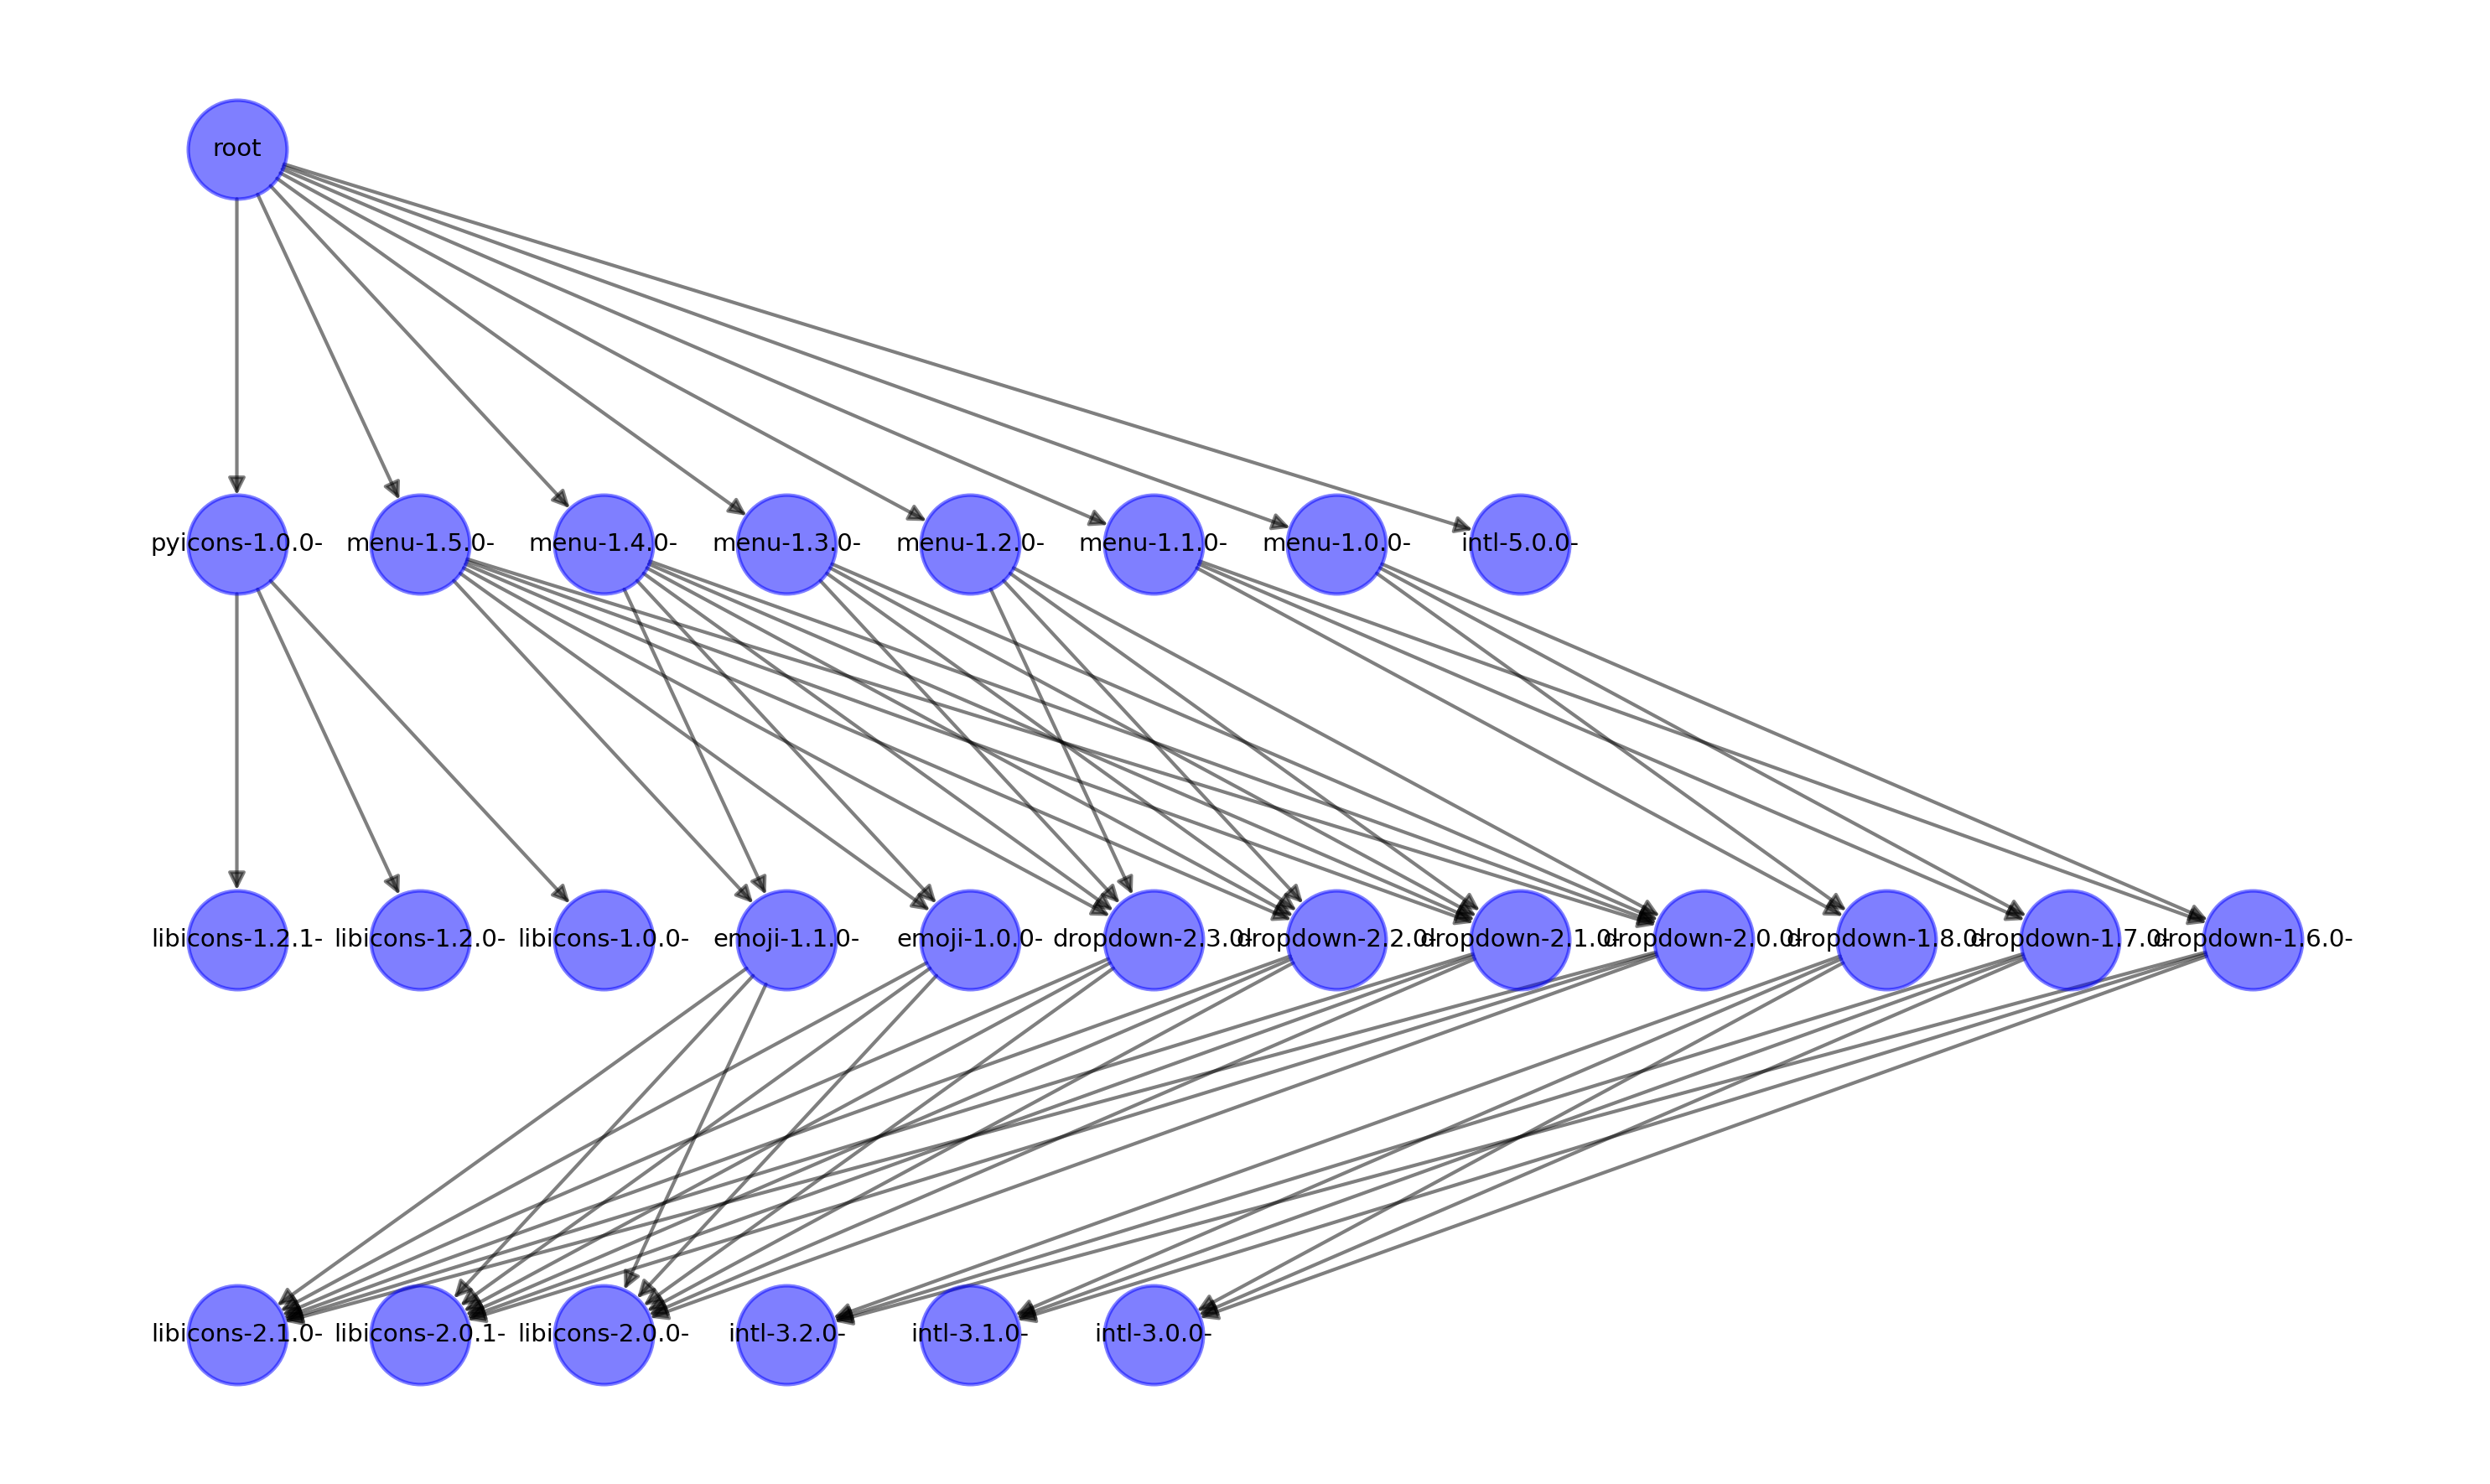

In [10]:
g = build_problem_graph_solvable(pbs, solvables, deps)
plot_dag(g)

In [11]:
def all_equal(*args):
    return all(a == b for a, b in itertools.pairwise(args))

assert all_equal()
assert all_equal(1)
assert all_equal(2, 2)
assert all_equal(2, 2, 2)
assert not all_equal(2, 2, 2, 1, 2)


@dataclasses.dataclass
class Dependency:
    id: int
    name: str
    parent_nodes: Set[str] = dataclasses.field(default_factory=set)
    solvable_nodes: Set[int] = dataclasses.field(default_factory=set)
    

@dataclasses.dataclass
class PackageSet:
    package_name: str
    parent_nodes: Set[int] = dataclasses.field(default_factory=set)
    solvable_nodes: Set[int] = dataclasses.field(default_factory=set)
    solvable_versions: List[str] = dataclasses.field(default_factory=list)

    @property
    def name(self) -> str:
        return f"{self.package_name}-({'|'.join(self.solvable_versions)})"
    
    # Hacky id not from libsolv
    @property
    def id(self) -> int:
        return id(self)


# Kind of redundant function since we had that information in the dataframes.
def get_dependency(graph: nx.DiGraph, dep_id: int) -> Dependency:
    dependency = Dependency(id=dep_id, name=None)
    for n, s in graph.edges:
        if graph.edges[(n, s)].get("dependency_id") == dep_id:
            dependency.name = graph.edges[(n, s)]["dependency"]
            dependency.parent_nodes.add(n)
            dependency.solvable_nodes.add(s)
    return dependency


def is_fully_compressable_dependency(graph: nx.DiGraph, dependency: Dependency) -> bool:
    return all_equal(*(list(graph.successors(n)) for n in dependency.solvable_nodes))


def compressable_solvable_graph(graph: nx.DiGraph, nodes: Sequence[int]) -> nx.Graph:
    compatibles = nx.Graph()
    compatibles.add_nodes_from(nodes)

    children = {n: set(graph.successors(n)) for n in nodes}
    compatibles.add_edges_from((n1, n2) for n1, n2 in itertools.combinations(nodes, 2) if children[n1] == children[n2])
                
    return compatibles


def greedy_clique_partition(graph: nx.Graph) -> List[List[int]]:
    graph = graph.copy()
    cliques = []
    while len(graph) > 0:
        max_clique = max(nx.find_cliques(graph), key=len)
        cliques.append(max_clique)
        graph.remove_nodes_from(max_clique)
    return cliques


def dependency_set_compression(graph: nx.DiGraph, dependency: Dependency) -> Iterator[PackageSet]:
    solvable_sets = greedy_clique_partition(compressable_solvable_graph(graph, dependency.solvable_nodes))
    for s in solvable_sets:
        # They are sorted
        if len(s) <= 1:
            continue
        yield PackageSet(
            package_name=graph.nodes[s[0]]["name"],
            parent_nodes=dependency.parent_nodes,
            solvable_nodes=set(s),
            solvable_versions=[graph.nodes[n]["version"] for n in s],
        )


def compressable_dependencies(graph: nx.DiGraph, dep_ids: Sequence[int]) -> Iterator[Union[Dependency, PackageSet]]:
    for id in dep_ids:
        d = get_dependency(graph, id)
        if len(d.solvable_nodes) > 1 and is_fully_compressable_dependency(graph, d):
            yield d
    for id in dep_ids:
        d = get_dependency(graph, id)
        if len(d.solvable_nodes) > 1:  
                yield from dependency_set_compression(graph, d)



# TODO Must compress the case where different dependencies resolve to the same solvables
# TODO Must compress solvables ranges that are a subset of a dependency
def compress_dependencies(graph: nx.DiGraph, dep_ids: Sequence[int]):
    graph = graph.copy()
    # This generator changes its value as the graph is modified!
    for d in compressable_dependencies(graph, dep_ids):
        # Add new dependency node and redirect dependency predecessor to it
        graph.add_node(d.id, repr=d.name, dependency=d.name)
        graph.add_edges_from(((p, d.id) for p in d.parent_nodes), dependency_id=d.id, dependency=d.name)
        solvable_sample = next(iter(d.solvable_nodes))  # TODO does not work with empty
        children = graph.successors(solvable_sample)
        for c in children:
            # Rebuild edge attributes
            graph.add_edge(d.id, c, **graph.edges[(solvable_sample, c)])
        # Remove old edges, and solvable nodes that don't have parent
        graph.remove_edges_from((p, s) for s in d.solvable_nodes for p in d.parent_nodes)
        graph.remove_nodes_from(s for s in d.solvable_nodes if (graph.in_degree(s) == 0))
    return graph   

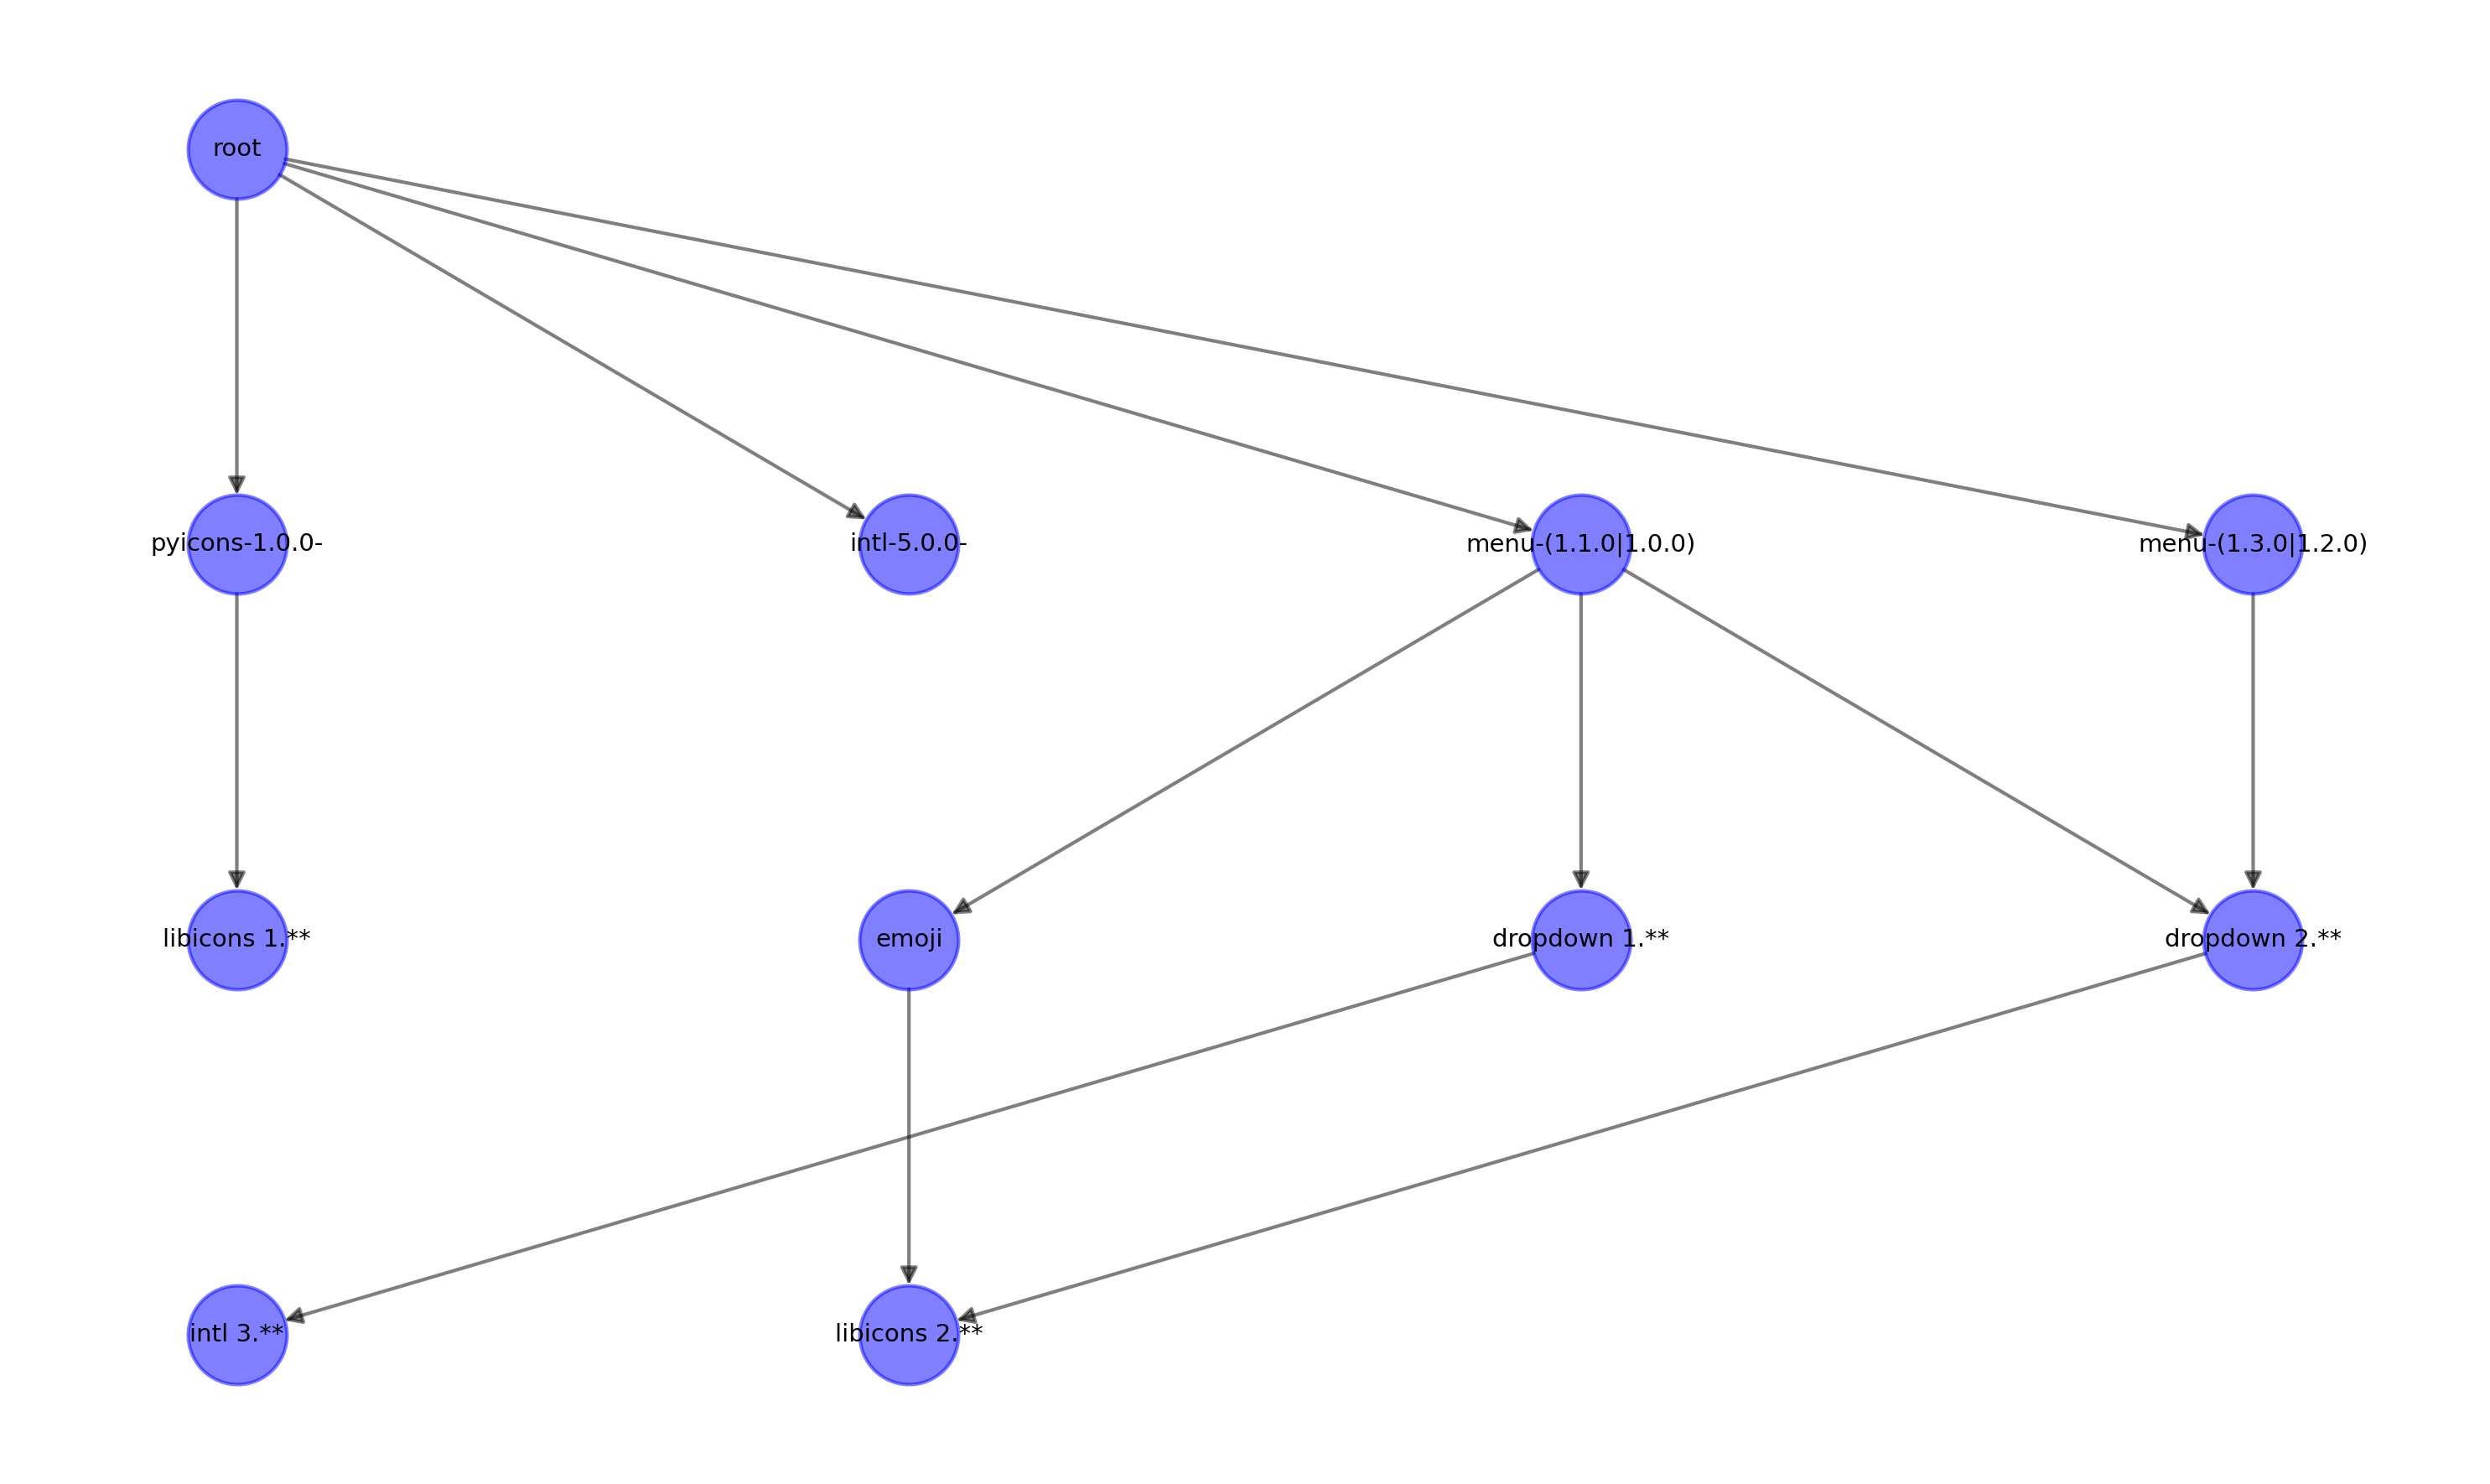

In [12]:
g_compressed = compress_dependencies(
    build_problem_graph_solvable(pbs, solvables, deps),
    deps.dependency_id.unique().tolist()
)
plot_dag(g_compressed)

In [13]:
def get_root_ancestor(graph: nx.DiGraph, node: int):
    root_parents = set()
    visited = {node}
    while len(visited) > 0:
        n = visited.pop()
        parents = set(graph.predecessors(n))
        if len(parents) > 0:
            visited = visited.union(parents)
        else:
            root_parents.add(n)
    return root_parents

            
def explain_errors(graph: nx.DiGraph):
    # leaves = [n for n in graph.nodes() if graph.in_degree(n) >= 1]
    leaves = [n for n in graph.nodes() if graph.out_degree(n) == 0 and graph.in_degree(n) >= 1]

    # print([str(graph.nodes[l]["pkg_info"]) for l in leaves])
    conflicts = {}
    for leaf in leaves:
        leaf_pkg_repr = "{name}-{version}-{build_string}".format(**graph.nodes[leaf])
        leaf_in_dependencies = set(
            graph.edges[e]["dependency"] for e in graph.in_edges(leaf)
        )
        
        ancestors = get_root_ancestor(graph, leaf)
        ancestor_pkg_repr = ["{name}-{version}-{build_string}".format(**graph.nodes[n]) for n in ancestors]
        ancestor_out_dependencies = set(
            graph.edges[e]["dependency"] for a in ancestors for e in graph.out_edges(a) 
        )
        print(f"Leaf: {leaf_pkg_repr}")
        print("  has dependencies " + " & ".join(leaf_in_dependencies))
        print(f"Ancestor: " + ", ".join(ancestor_pkg_repr))
        print("  has dependencies " + " & ".join(ancestor_out_dependencies))
        print()

In [14]:
explain_errors(g)

Leaf: libicons-2.1.0-
  has dependencies libicons 2.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: libicons-2.0.1-
  has dependencies libicons 2.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: libicons-2.0.0-
  has dependencies libicons 2.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: libicons-1.2.1-
  has dependencies libicons 1.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: libicons-1.2.0-
  has dependencies libicons 1.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: libicons-1.0.0-
  has dependencies libicons 1.**
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: intl-5.0.0-
  has dependencies intl 5.*
Ancestor: root-None-None
  has dependencies intl 5.* & pyicons 1.* & menu

Leaf: intl-3.2.0-
  has dependencies intl 3.**
Ancestor: root-None-None
  has dependencies intl 5.*